In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [4]:
spark = SparkSession.builder.master("local[4]").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/18 13:52:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Importation des données

In [5]:
rdd_crct = spark.sparkContext.textFile('accidents/caracteristiques*.csv')
rdd_usg = spark.sparkContext.textFile('accidents/usagers*.csv')
rdd_lieux = spark.sparkContext.textFile('accidents/lieux*.csv')
rdd_vhc = spark.sparkContext.textFile('accidents/vehicules*.csv')

#### Extraction des noms des colonnes avec la méthode first()

In [6]:
head_crct = rdd_crct.first()
head_usg = rdd_usg.first()
head_vhc = rdd_vhc.first()
head_lieux = rdd_lieux.first()

# Nombre de morts par tranche d'âge et par sexe

#### Création d'une fonction qui compte le nombre de morts pour chaque tranche d'âge et qui prend en compte le sexe

La fonction traite le rdd usagers et prend en entrée l'année et le sexe.
1) enlève tous les premières lignes de chaque fichier
2) sélèctionne les colonnes utiles à l'analyse (Numéro d'accidents, gravité, sexe, année de naissance)
3) extrait l'année de l'accident en prenant les 4 premières caractères de chaque élément de la colonne
4) filtre tous les accidents mortels ('grav' == 2)
5) filtre le sexe (1 ou 2)
6) enlève les années de naissance non répértoriées
7) calcule l'âge de l'usager (colonne 1 - colonne 4)
8) classe chaque usager dans une tranche d'âge de 10 ans 
9) groupe en fonction de la tranche d'âge
10) compte le nombre de morts dans chaque tranche d'âge
11) trie en fonction de l'âge

In [7]:
def nb_morts(annee,sexe):
    """ compte le nombre de morts par tranche d'âge de 10 ans et par sexe"""
    
    return rdd_usg\
    .filter(lambda t: t != head_usg)\
    .map(lambda t: [t.split(',')[i] for i in [0,3,4,10]])\
    .filter(lambda t: t[0][:4] == str(annee))\
    .filter(lambda t: t[1] == '2')\
    .filter(lambda t: t[2] == str(sexe))\
    .filter(lambda t: (  t[3] != ''))\
    .map(lambda t: int(t[0][:4])-int(t[3]))\
    .map(lambda t: "{0}0-{0}9".format(t//10) if t < 90 else "90 ans et +")\
    .groupBy(lambda t:t)\
    .mapValues(len)\
    .sortByKey()

In [8]:
nb_morts(2018,1).collect()

[('00-09', 34),
 ('10-19', 201),
 ('20-29', 582),
 ('30-39', 395),
 ('40-49', 361),
 ('50-59', 364),
 ('60-69', 261),
 ('70-79', 196),
 ('80-89', 174),
 ('90 ans et +', 47)]

##### Jointure du nombre de morts chez les femmes et chez les hommes 

Il s'agit ici de lier le nombre de morts en une même année chez les hommes et les femmes pour faire des comparaisons.
1) jointure de deux rdd avec join
2) trie en fonction de la tranche d'âge
3) rend un tuple avec la tranche d'âge, le nb de morts chez les hommes, le nb de morts chez les femmes (ex: ('10-19', '201', '54'))
4) conversion en data frame et en pandas 
5) indexation du dafaframe par la tranche d'âge
6) représentation avec un barplot

In [9]:
plt.style.use('ggplot')
def mortalite_selon_age_sexe(annee):
    df = nb_morts(annee, 1).join(nb_morts(annee,2))\
    .sortByKey()\
    .map(lambda x: (x[0], x[1][0], x[1][1]))\
    .toDF()\
    .toPandas()\
    .set_index('_1')
    df.plot(kind = 'bar', title = f"Nombre de morts sur les routes en {annee} par tranche d'âges de 10 et par sexe", figsize = (12,6), rot = 30).set_xlabel(None)
    plt.legend(['Hommes', 'Femmes'])

Exemple avec l'année 2017

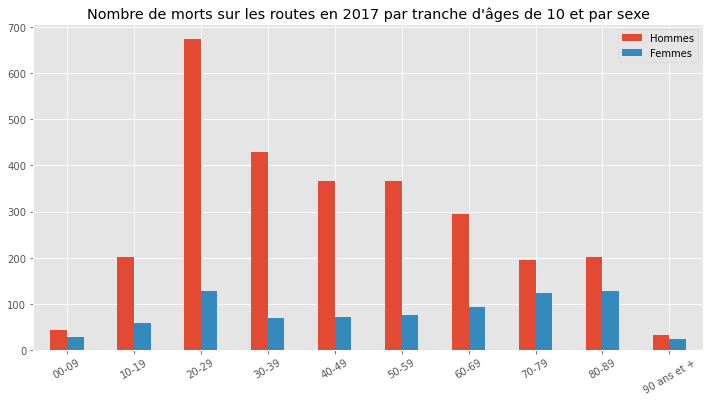

In [10]:
mortalite_selon_age_sexe(2017)

Exemple avec l'année 2013

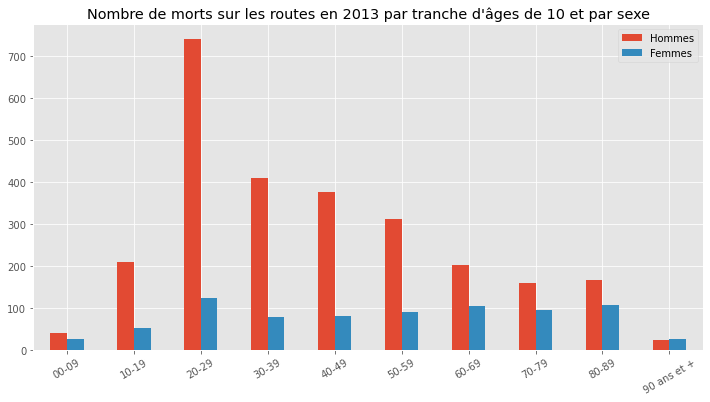

In [11]:
mortalite_selon_age_sexe(2013)

**Conclusion**: On remarque que les tranches d'âge les plus à risque d'être touchés par les accidents mortels sont les hommes entre 20 et 30 ans. \
Chez les femmes, le risque d'accidents mortels augment petit à petit à partir de 30 ans et se rapproche au risque d'accidents mortels des hommes à partir de 70 ans.

# Accidents sur différents type de route et de luminosité hors jour, exprimé en fonction du mois de l'année


Filtrage des accidents en fonction du type de lumière et du mois

1) Séléction des colonnes mois et lumière
2) enlève tous les accidents en plein jour 
3) format (Num_Acc, (mois, lum))

In [12]:
crct_lum = rdd_crct\
    .filter(lambda x: (x != head_crct))\
    .map(lambda x: [x.split(',')[i] for i in [0,2,5]])\
    .filter(lambda x: (x[2] != '1'))\
    .map(lambda t: [t[0],(t[1],t[2])])

Filtrage du lieu en fonction du type de la route 

In [13]:
lieux_cat = rdd_lieux\
    .filter(lambda x: (x != head_lieux))\
    .map(lambda x: [x.split(',')[i] for i in [0,1]])

Pour que l'étude soit plus intéressante, je décide de regrouper toutes les catégories de routes hors autoroute, route nationale, départementale, communale.
Je les affecte à la valeur 7

In [14]:
lieux_tiers = lieux_cat\
    .filter(lambda x:(x[1] == '5') | (x[1] == '6') | (x[1] == '9'))\
    .map(lambda x: [x[0], '7'])

Cela implique qu'il faut retirer ces routes dans le rdd principal

Filtrage des lieux principales

In [15]:
lieux = lieux_cat\
    .filter(lambda x:x[1] != '5')\
    .filter(lambda x:x[1] != '6')\
    .filter(lambda x:x[1] != '9')

Assemblage des deux lieux 

In [16]:
lieux_cat = lieux.union(lieux_tiers)

Jointure des deux rdd et filtrage de l'information demandé:
- Groupe en fonction du mois, du type de lumière et du type de route
- trie en fonction du mois 
- retourne le nombre d'accidents de chaque mois en fonction de la lumière ou du type de route

In [17]:
df = crct_lum\
    .join(lieux_cat)\
    .map(lambda x: (int(x[1][0][0]), x[1][0][1], x[1][1]))\
    .groupBy(lambda x: (x[0],x[1],x[2]))\
    .sortByKey()\
    .mapValues(len)\
    .map(lambda h: (h[0][0],h[0][1],h[0][2],h[1]))\
    .toDF()\
    .toPandas()\
    .set_index('_1')

In [18]:
df = df.rename(columns={'_1': 'Mois', '_2': "Conditions d'éclairage", '_3': "Catégorie de route", '_4': "Nombre d'accidents"})
sns.set_theme()

In [19]:
df.tail()

,Conditions d'éclairage,Catégorie de route,Nombre d'accidents
_1,,,
12,5,1,327
12,5,2,491
12,5,3,2978
12,5,4,7866
12,5,7,276


Représentation avec seaborn

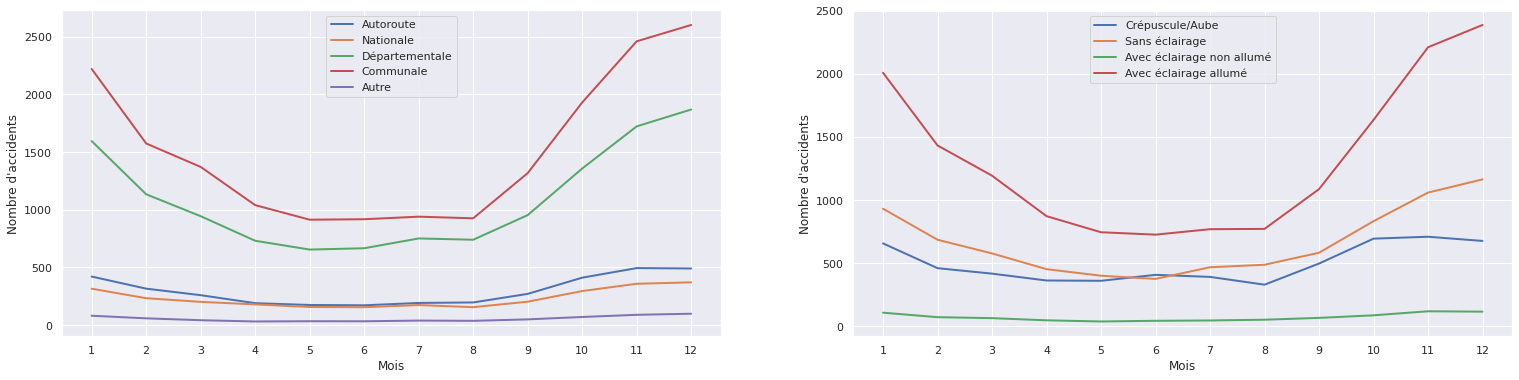

In [20]:
fig, axes = plt.subplots(1,2, figsize = (26,6))
#route
sns.lineplot(ax = axes[0], data = df, x = '_1', y = "Nombre d'accidents", hue = 'Catégorie de route', errorbar= None, lw= 2).set_xticks(range(1,13,1))
axes[0].legend(labels=['Autoroute','Nationale', 'Départementale', 'Communale', 'Autre'])
axes[0].set_xlabel('Mois')

#lumière
sns.lineplot(ax = axes[1], data = df, x = '_1', y = "Nombre d'accidents", hue = "Conditions d'éclairage", errorbar= None, lw = 2).set_xticks(range(1,13,1))
axes[1].legend(labels=['Crépuscule/Aube','Sans éclairage', 'Avec éclairage non allumé', 'Avec éclairage allumé'])
axes[1].set_xlabel('Mois');

**Conclusion**:
Le nombre d'accidents durant la nuit est multiplié par de aôut à octobre, celà s'explique notamment par l'augmentation des gens qui circulent(notamment avec la fin des vacances et la rentrée) mais aussi le changemet d'horaire qui implique qu'on roule forcément sans lumière pour rentrer après le travail. \
Concernant le type de route, les accidents se font plus sur les routes départementales et communales. Le nombre d'accidents sur les autoroutes et les routes nationales est moins élevé, car ces derniers sont plus sécurisés que les autres.


# Répartition de la gravité de l'accident en fonction du type de choc

On veut exprimer la gravité de l'accident en fonction du type de choc subi par le véhicule lors de l'accident. \
Pour cela, on lie les rdd usagers et véhicules, par l'intermédiaire des colonnes gravité et choc. \
On extrait donc la colonne gravité avec un map split. On fait de même pour choc, et on enlève les valeurs nulles avec filter. 

In [21]:
gravite = rdd_usg\
    .filter(lambda x: (x != head_usg))\
    .map(lambda x: [x.split(',')[i] for i in [0,3]])
choc = rdd_vhc\
    .filter(lambda x: (x != head_vhc))\
    .map(lambda x: [x.split(',')[i] for i in [0,6]])\
    .filter(lambda x: x[1] != '0')
rdd_grv_choc = gravite\
    .join(choc)\
    .sortByKey()

In [22]:
rdd_grv_choc.take(5)

[('201100000001', ('3', '1')),
 ('201100000001', ('3', '6')),
 ('201100000001', ('1', '1')),
 ('201100000001', ('1', '6')),
 ('201100000002', ('1', '2'))]

Initiation une liste qui contient les points de choc initiaux

In [23]:
liste_chocs = {'1':'Avant', '2':'Avant droit', '3':'Avant gauche', '4':'Arrière', '5':'Arrière droit', '6':'Arrière gauche', '7':'Côté droit', '8':'Côté gauche', '9':'Chocs mutliples'}

Création d'une fonction type_choc_grav qui prend en argument le type de choc et retourne le nombre d'accidents par gravité:
1) Prend les colonnes (gravité, choc) et filtre en fonction du type de choc
2) Groupe en fonction du type de gravité
3) Compte le nombre d'accidents par type de gravité, et trie par type de gravité
4) Renomme le numéro du type de choc par le nom du type de choc

In [24]:
def type_choc_grav(key,value):
    return rdd_grv_choc\
        .map(lambda x: [x[1][0], x[1][1]]).filter(lambda x: x[1] == key)\
        .groupBy(lambda x: x[0])\
        .mapValues(len).sortByKey()\
        .map(lambda x: (value,x[1]))

In [25]:
type_choc_grav('1', 'Avant').collect()

[('Avant', 310262), ('Avant', 18961), ('Avant', 146477), ('Avant', 259008)]

Pour tous les types de choc, j'execute la fonction type_choc_grav

In [26]:
data_choc = [type_choc_grav(cle,valeur) for cle, valeur in liste_chocs.items()]

Rassemblement de toutes les données avec la fonction union

In [27]:
rdd_choc = spark.sparkContext.union(data_choc)
rdd_choc.take(5)

[('Avant', 310262),
 ('Avant', 18961),
 ('Avant', 146477),
 ('Avant', 259008),
 ('Avant droit', 99793)]

Réduction en fonction des keys pour obtenir chaque nombre d'accidents de chaque type de gravité, sachant que les types de gravité ont été trié et sont de l'ordre (1,2,3,4) \
On transpose le dataframe pour la représentation

In [28]:
data = rdd_choc\
    .reduceByKey(lambda a,b: [a,b])\
    .map(lambda a: (a[0], a[1][0][0][0], a[1][0][0][1], a[1][0][1], a[1][1])) \
    .toDF()\
    .toPandas()\
    .set_index('_1')\
    .T

Obtention d'un data frame pandas 

In [29]:
data.insert(0,'Gravité', ['indemne','tué','hospitalisé','blessé léger'])
data

_1,Gravité,Avant gauche,Avant droit,Arrière gauche,Chocs mutliples,Côté droit,Arrière,Avant,Côté gauche,Arrière droit
_2,indemne,125080,99793,37674,11037,50910,133555,310262,62132,28788
_3,tué,8691,5355,1283,1481,2927,1969,18961,3270,763
_4,hospitalisé,61812,43280,11458,7655,21595,23132,146477,26138,8300
_5,blessé léger,96716,75768,25447,11200,41759,96542,259008,48756,19705


In [30]:
data.to_csv('accidents_chocs.csv')
df_acc = pd.read_csv('accidents_chocs.csv', index_col=0)
df_acc

,Gravité,Avant gauche,Avant droit,Arrière gauche,Chocs mutliples,Côté droit,Arrière,Avant,Côté gauche,Arrière droit
_2,indemne,125080,99793,37674,11037,50910,133555,310262,62132,28788
_3,tué,8691,5355,1283,1481,2927,1969,18961,3270,763
_4,hospitalisé,61812,43280,11458,7655,21595,23132,146477,26138,8300
_5,blessé léger,96716,75768,25447,11200,41759,96542,259008,48756,19705


Visualisation avvec plolty dans le fichier grav_dash.py
(installation nécessaire de plotly et de Dash)